In [1]:
import os

os.chdir("..")

In [2]:
import pandas as pd

data = pd.read_csv("artifacts/data/gta-crash/train.csv")

In [3]:
data[['filename', 'target']]

,filename,target
0,00000_00.jpg,1
1,00000_01.jpg,1
2,00000_02.jpg,1
3,00000_03.jpg,1
4,00000_04.jpg,1
...,...,...
227615,11380_15.jpg,0
227616,11380_16.jpg,0
227617,11380_17.jpg,0
227618,11380_18.jpg,0


In [5]:
data.target.value_counts()

target
1    154400
0     73220
Name: count, dtype: int64

### The distribution of target is 10 : 21. Its imbalance Lets not bother about it a lot

In order to train a model : 
- Model
- Data retrieving class venam
- Optimization Algorithm venam

In [6]:
# Lets create datasets 

from torch.utils.data import Dataset
import cv2

class CrashDataset(Dataset):
    def __init__(self, data, img_dir):
        self.data = data
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR_RGB)
        image = cv2.resize(image, (224, 224))
        label = row['target']
        return image, label

In [7]:
from torch.utils.data import DataLoader

train_dataset = CrashDataset(data, "artifacts/data/gta-crash/train_images")
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
image, label = train_dataset[1]

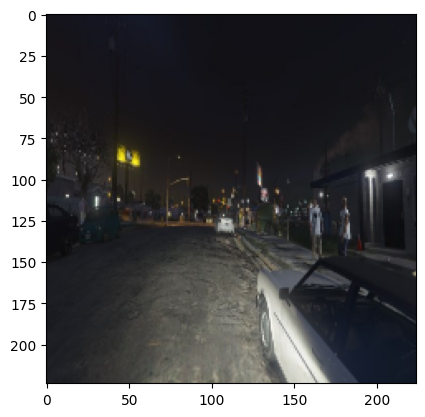

In [8]:
import matplotlib.pyplot as plt

plt.imshow(image)

In [13]:
# Now we can build a simple pytorch model for baseline training
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.backends.mps import is_available


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 112 * 112, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = x.reshape(-1, 16 * 112 * 112)
        x = self.fc1(x)
        return x
    
model = SimpleCNN()
device = torch.device("mps" if is_available() else "cpu")
model.to(device)
print(device)

mps


In [ ]:
# from tqdm import tqdm
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
from tqdm import tqdm
num_epochs = 10
sample_image, sample_label = next(iter(dataloader))

for epoch in range(num_epochs):
    model.train()
    sample_image = sample_image.permute(0, 3, 1, 2).float().to(device)
    sample_label = sample_label.float().unsqueeze(1).to(device)

    optimizer.zero_grad()
    outputs = model(sample_image)
    loss = criterion(outputs, sample_label)
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [12]:
from tqdm import tqdm
num_epochs = 10
avg_loss = 0.0
n_batches = len(dataloader)

for epoch in range(num_epochs):
    for image, label in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", total=len(dataloader)):
        images = image.permute(0, 3, 1, 2).float().to(device)
        labels = label.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()

    avg_loss /= n_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    avg_loss = 0.0

Epoch 1/10:   0%|          | 6/3557 [00:21<3:34:00,  3.62s/batch]


KeyboardInterrupt: 

In [131]:
# Lets get the predictions of this sample batch
from sklearn.metrics import classification_report, confusion_matrix
with torch.no_grad():
    images = sample_image.permute(0, 3, 1, 2).float().to(device)
    outputs = model(images)
    predicted = torch.sigmoid(outputs).cpu().numpy()
    predicted_labels = (predicted > 0.5).astype(int)
    print("Predicted labels:", predicted_labels.flatten())
    print("Actual labels:", sample_label.numpy())

Predicted labels: [1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Actual labels: [1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1]


In [132]:
print(classification_report(sample_label.numpy(), predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.32      0.46        25
           1       0.69      0.95      0.80        39

    accuracy                           0.70        64
   macro avg       0.74      0.63      0.63        64
weighted avg       0.73      0.70      0.66        64



In [133]:
confusion_matrix(sample_label.numpy(), predicted_labels)

array([[ 8, 17],
       [ 2, 37]])